# This spread sheet uses surface temperaturue measurements along with Other met and canopy variables and estimates of Rn G to give estimates of ET and compares with measurements

In [32]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ETFunctions
%matplotlib inline
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
import lmfit as fitter
import ETFunctions as et
from datetime import datetime
import matplotlib.dates as mdates
import MathsUtilities as MUte

## Bring in data

### Bring in the cover Data

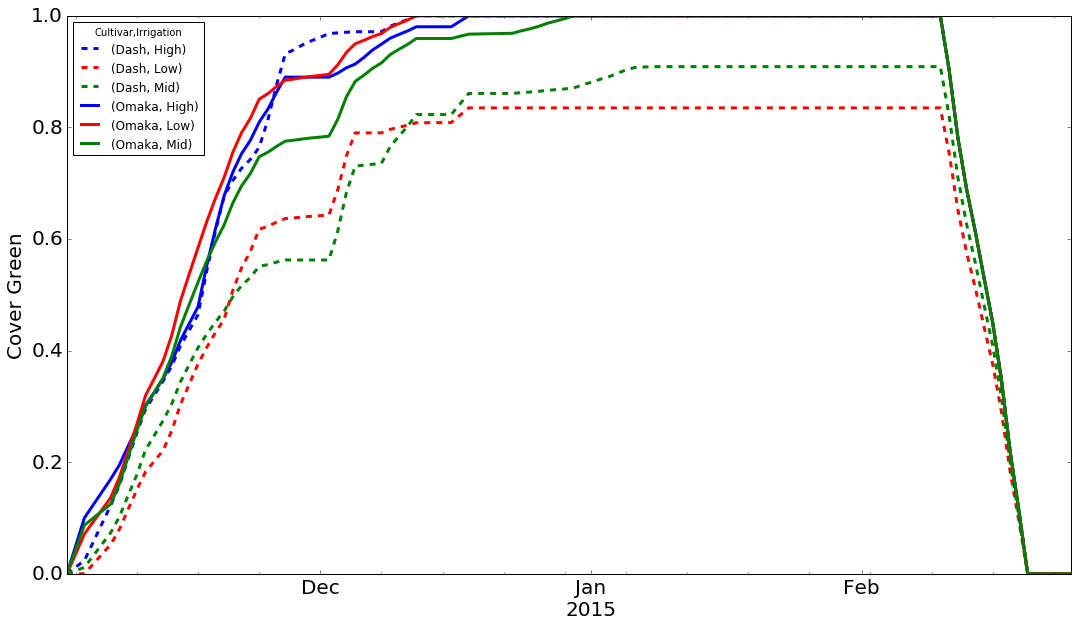

In [2]:
CoverData = pd.read_pickle('.\DataFrames\DailyFPAREstInt.pkl')
CoverData.sort_index(axis=1,inplace=True)
CoverData.groupby(level=['Cultivar','Irrigation'],axis=1).mean().plot(fontsize = 20, figsize=(18,10),style=['b--','r--','g--','b-','r-','g-'],linewidth = 3)
plt.ylabel('Cover Green', fontsize = 20)

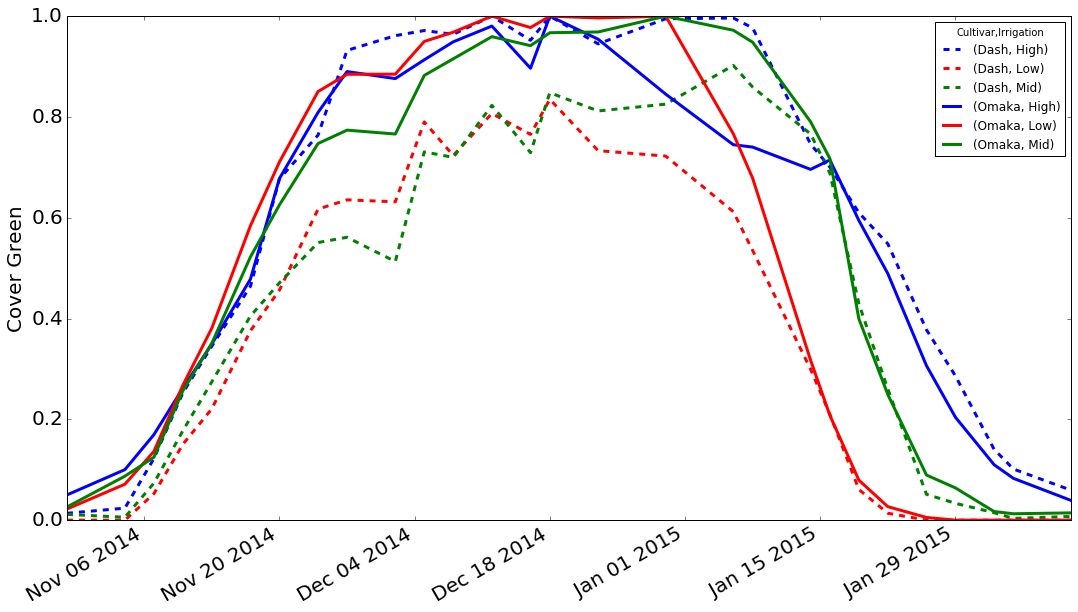

In [3]:
GreenCoverData = pd.read_pickle('.\DataFrames\FPARGreenEstimated.pkl')
GreenCoverData.sort_index(axis=1,inplace=True)
GreenCoverData.groupby(level=['Cultivar','Irrigation'],axis=1).mean().plot(fontsize = 20, figsize=(18,10),style=['b--','r--','g--','b-','r-','g-'],linewidth = 3)
plt.ylabel('Cover Green', fontsize = 20)

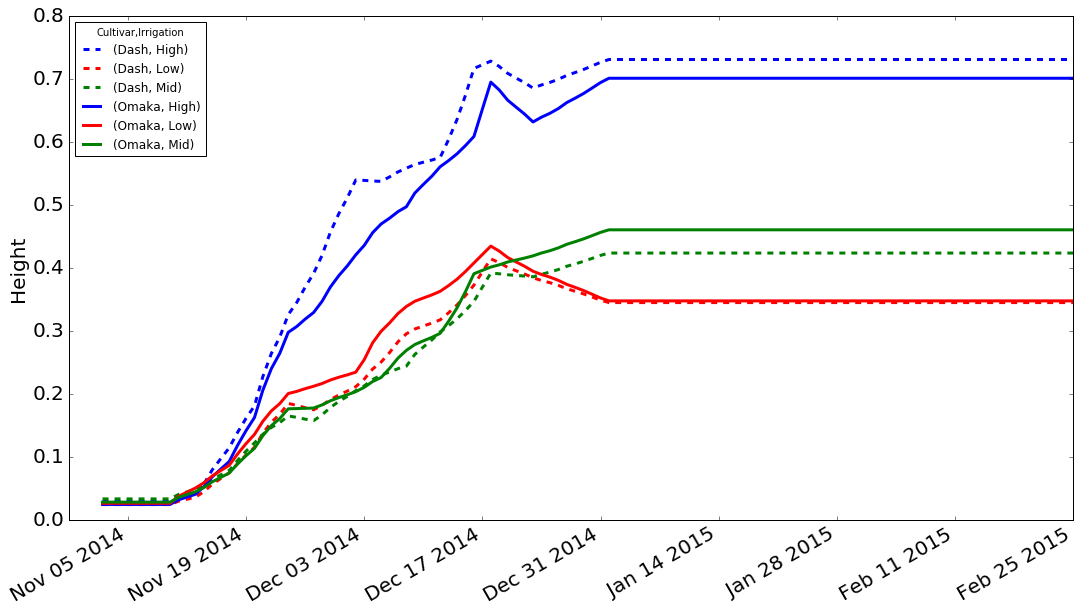

In [4]:
HeightData = pd.read_pickle('.\DataFrames\HeightEstimated.pkl')
HeightData.sort_index(axis=1,inplace=True)
HeightData.groupby(level=['Cultivar','Irrigation'],axis=1).mean().plot(fontsize = 20, figsize=(18,10),style=['b--','r--','g--','b-','r-','g-'],linewidth = 3)
plt.ylabel('Height', fontsize = 20)

## Bring in the Energy Balance Data

In [5]:
EstRn = pd.read_pickle('.\DataFrames\EstNetRadiation.pkl')
EstG= pd.read_pickle('.\DataFrames\SoilHeatFluxDayEst.pkl')
HourlyWateruse = pd.read_pickle('.\DataFrames\HourlyWUmm.pkl')
HourlyWateruse.sort_index(axis=1,inplace=True)
TnRData = pd.read_pickle('.\DataFrames\TempAndMet.pkl')
TnRData.sort_index(axis=1,inplace=True)
TnRData.index.name='Date'
DayTimePET = pd.read_pickle('.\DataFrames\DayTimePET.pkl')
DayTimePET.index = DayTimePET.index.normalize()
TsULTa = pd.read_pickle('.\DataFrames\TsTaULDF.pkl')
ECT = '2014-11-08 00:00:00'
LCT = '2015-02-11 00:00:00'

Albedo = 0.23
Lattitude = -43.38
LongitudeTZ = 185
LongitudeML = 360 - 172.28
Cp = 1013 #Heat capacity of air Joule/kg/oC
#D=1200
D0 = 4000
T0 = 6
E1 = -0.00015
E0 = -0.0005
E = -0.0005
C1 = 1.2
C0 = 2
CB = 0.6
##Contract dataframes down to common index size
TnRData = TnRData.ix[ECT:LCT,:]

Irrigations = ['Low','Mid','High']
Cultivars = ['Dash','Omaka']
PlotList = [('Dash','Low','1'),('Dash','Low','2'),('Dash','Low','3'),('Dash','Low','4'),
('Dash','Mid','1'),('Dash','Mid','2'),('Dash','Mid','3'),('Dash','Mid','4'),
('Dash','High','1'),('Dash','High','2'),('Dash','High','3'),('Dash','High','4'),
('Omaka','Low','1'),('Omaka','Low','2'),('Omaka','Low','3'),('Omaka','Low','4'),
('Omaka','Mid','1'),('Omaka','Mid','2'),('Omaka','Mid','3'),('Omaka','Mid','4'),
('Omaka','High','1'),('Omaka','High','2'),('Omaka','High','3'),('Omaka','High','4')]

## Do some processing and cleaning

In [6]:
#Create a list of time to exclude where data was missing or irrigation was applied
NoMeasurementDates = ['2014-12-26','2014-12-27','2014-12-28']
IrrigationDates = ['2014-11-11','2014-11-18','2014-11-26','2014-12-02','2014-12-10','2014-12-16',
                    '2014-12-23','2014-12-30','2015-01-06','2015-01-13','2015-01-14']

ExclusionDates = IrrigationDates
for Date in NoMeasurementDates:
    ExclusionDates.append(Date)

#Exclude data from Temperature and radiation dataframe
ExclusionDateTimes5 = []
for Date in ExclusionDates:
    ExclusionDateTimes5 += pd.date_range(Date,periods=288,freq='5T')
TnRData = TnRData.ix[~TnRData.index.isin(ExclusionDateTimes5)]

# Make an index of all daylight hours in trial
HourlyTnRDataSum = TnRData.resample('h').sum()
HourlyTnRDataMean = TnRData.resample('h').mean()
DaylightIndex = HourlyTnRDataSum.ix[:,'IncomingRadnMJ'].where(HourlyTnRDataSum.ix[:,'IncomingRadnMJ']>0.02)
DaylightIndex.dropna(inplace=True)
DaylightIndex = DaylightIndex.index.to_datetime()

# Make day time means and sums for temperature and radiation data
DayTimeTnRDataMean = HourlyTnRDataMean.ix[DaylightIndex].resample('d').mean()
DayTimeTnRDataSum = HourlyTnRDataSum.ix[DaylightIndex].resample('d').sum()

# Make daily (day time) ET dataframe from hourly data excluding dark periods
ET = HourlyWateruse.ix[DaylightIndex].resample('d').sum()
ET = ET.ix[~ET.index.isin(ExclusionDates)]
ET = ET*-1
ET.index.name = 'Date'
ET.columns = ET.columns.swaplevel('Irrigation','Cultivar')

#Exclude non measurement and irrigation dates from Rn and G data frames
EstRn = EstRn.ix[~EstRn.index.isin(ExclusionDates, level=3)]
EstG = EstG.ix[~EstG.index.isin(ExclusionDates)]

#Exclude data from Surface Temperature upper limit dataframe and make daily mean
TsULTa = TsULTa.ix[~TsULTa.index.isin(ExclusionDateTimes5)]
HourlyTsULTa = TsULTa.resample('h').mean()
DayTimeTsULTaMean = TsULTa.ix[DaylightIndex].resample('d').mean()

## Make a data frame with estimated energy balance components

In [7]:
def makeSeries(Var,Frame):
    SSeries= Frame.ix[Var]
    SSeries.name = Var
    SSeries.index = SSeries.index.droplevel()
    SSeries.index = SSeries.index.droplevel()
    return SSeries

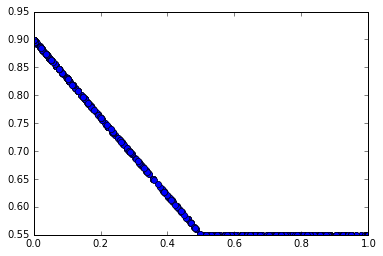

In [24]:
#Start off data frame with net radiation data W/m2
EstRn.name = 'EstRn'
EstEnergyBalance = pd.DataFrame(EstRn)

#Make soil heat flux data long and join into energy balance data frame
EstG.index.name='Date'
EstGLong = EstG.unstack()
EstGLong.name = 'EstG'
EstEnergyBalance = EstEnergyBalance.join(EstGLong)

#Make surface temperature data long and join into energy balance data frame
TsTa = np.subtract(DayTimeTnRDataMean.ix[:,'IR_SurfaceTemp'] , DayTimeTnRDataMean.ix[:,'AirTemperature'])
TsTaLong = TsTa.unstack()
TsTaLong.name = 'Ts-Ta'
EstEnergyBalance = EstEnergyBalance.join(TsTaLong)

#Make surface temperature limit data long and join into energy balance data frame
DayTimeTsULTaMean.index.name = 'Date'
TsULTaLong = DayTimeTsULTaMean.unstack()
TsULTaLong.name = 'TsUL-Ta'
EstEnergyBalance = EstEnergyBalance.join(TsULTaLong)

#Duplicate Experiment level met data across all treatments and join into energy balance data frame
DateSet = EstEnergyBalance.ix[('Dash','Low','1'),:].index
TnRDataLong = DayTimeTnRDataMean.ix[DateSet].unstack()
LamdaSeries = makeSeries('lamda',TnRDataLong)
tempSeries = makeSeries('AirTemperature',TnRDataLong)
windSeries = makeSeries('Windspeed',TnRDataLong)
qSeries = makeSeries('q',TnRDataLong)
VPDSeries = makeSeries('VPD',TnRDataLong)
for plot in PlotList:
    #Hourly Water use in mm is equal to kg/m2 need to multiply by latent heat of vapourisation to convert to MJ
    EstEnergyBalance.ix[plot,'lamda'] = LamdaSeries.values
    EstEnergyBalance.ix[plot,'Ta'] = tempSeries.values
    EstEnergyBalance.ix[plot,'u'] = windSeries.values
    EstEnergyBalance.ix[plot,'q'] = qSeries.values
    EstEnergyBalance.ix[plot,'VPD'] = VPDSeries.values
    EstEnergyBalance.ix[plot,'PET'] = DayTimePET[EstEnergyBalance.ix[plot,'q'].index].values

#Join cover and green cover data into the data frame
EstEnergyBalance.ix[:,'Cover'] = CoverData.ix[DateSet].bfill().unstack()
EstEnergyBalance.ix[:,'GreenCover'] = GreenCoverData.ix[DateSet].bfill().unstack()
EstEnergyBalance.ix[:,'Height'] = HeightData.ix[DateSet].bfill().unstack()
    
#Calculate some other values    
EstEnergyBalance.ix[:,'qCp'] = EstEnergyBalance.ix[:,'q'] * Cp
EstEnergyBalance.ix[:,'uVPD'] = EstEnergyBalance.ix[:,'u'] * EstEnergyBalance.ix[:,'VPD']
EstEnergyBalance.ix[:,'Ts-TaqCp'] = EstEnergyBalance.ix[:,'Ts-Ta'] * EstEnergyBalance.ix[:,'q'] * Cp
EstEnergyBalance.ix[:,'EstRn-EstG'] = EstEnergyBalance.ix[:,'EstRn'] - EstEnergyBalance.ix[:,'EstG']

EstEnergyBalance.ix[:,'Ts'] = EstEnergyBalance.ix[:,'Ta'] + EstEnergyBalance.ix[:,'Ts-Ta']
EstEnergyBalance.ix[:,'To'] = EstEnergyBalance.ix[:,'Ts']  + 0 + EstEnergyBalance.ix[:,'VPD'] * 1
EstEnergyBalance.ix[:,'To-Ta'] =  EstEnergyBalance.ix[:,'To'] -  EstEnergyBalance.ix[:,'Ta'] 
EstEnergyBalance.ix[:,'TsUL'] = EstEnergyBalance.ix[:,'Ta'] + EstEnergyBalance.ix[:,'TsUL-Ta']
EstEnergyBalance.ix[:,'ToUL'] = EstEnergyBalance.ix[:,'TsUL'] + 0 +  EstEnergyBalance.ix[:,'VPD'] * 1
EstEnergyBalance.ix[:,'ToUL-Ta'] = EstEnergyBalance.ix[:,'ToUL'] - EstEnergyBalance.ix[:,'Ta']
EstEnergyBalance.ix[:,'(To-Ta)/(ToUL-Ta)'] = EstEnergyBalance.ix[:,'To-Ta']/EstEnergyBalance.ix[:,'ToUL-Ta']
EstEnergyBalance.ix[:,'(To-Ta)qCp'] = EstEnergyBalance.ix[:,'To-Ta'] * EstEnergyBalance.ix[:,'qCp']

#Calculate the bowen ratio
Var = 'GreenCover'
xCover = [0,0.5,1.0]
ySlope = [0.9,0.55,0.55]
EstEnergyBalance.ix[:,'Slope'] = np.interp(EstEnergyBalance.ix[:,Var],xCover,ySlope)
plt.plot(EstEnergyBalance.ix[:,Var],EstEnergyBalance.ix[:,'Slope'],'o')
EstEnergyBalance.ix[:,'EstH/(EstRn-EstG)'] = EstEnergyBalance.ix[:,'(To-Ta)/(ToUL-Ta)'] * EstEnergyBalance.ix[:,'Slope']
EstEnergyBalance.ix[:,'EstH/(EstRn-EstG)'] = [min(EstEnergyBalance.ix[x,'EstH/(EstRn-EstG)'],1) for x in range(EstEnergyBalance.index.size)]
EstEnergyBalance.ix[:,'EstH/(EstRn-EstG)'] = [max(EstEnergyBalance.ix[x,'EstH/(EstRn-EstG)'],-1) for x in range(EstEnergyBalance.index.size)]

#The IRR on rep 2 of Dash High went on the blink after the 10th of Jan but the Equations to calculate H/(Rn-G) treat the missing data as zero so we need to delet the results 
EstEnergyBalance.ix[('Dash','High','2'),'EstH/(EstRn-EstG)'].ix['2015-01-10':] = np.nan

#Calculate estimated values for H and ET
EstEnergyBalance.ix[:, 'EstH'] = EstEnergyBalance.ix[:, 'EstH/(EstRn-EstG)'] * EstEnergyBalance.ix[:,'EstRn-EstG']
EstEnergyBalance.ix[:,'EstlE'] = EstEnergyBalance.ix[:,'EstRn'] - EstEnergyBalance.ix[:,'EstG'] - EstEnergyBalance.ix[:,'EstH']
EstEnergyBalance.ix[:,'EstET'] = EstEnergyBalance.ix[:,'EstlE']/EstEnergyBalance.ix[:,'lamda']

#Make water use data long and join into energy balance dataset
ETLong = ET.unstack()
ETLong.name = 'ET'
EstEnergyBalance = EstEnergyBalance.join(ETLong)

#Calculate residual
EstEnergyBalance.ix[:,'ResidualET'] = EstEnergyBalance.ix[:,'ET'] - EstEnergyBalance.ix[:,'EstET']

#make a dataframe with treatment means
EstEBreorder = EstEnergyBalance.copy()
EstEBreorder.index = EstEnergyBalance.index.swaplevel('Date','Cultivar')
EstEBreorder.index = EstEnergyBalance.index.swaplevel('Irrigation','Block')
EBMeans = EstEBreorder.groupby(level=('Cultivar','Irrigation','Date'),axis=0).mean()

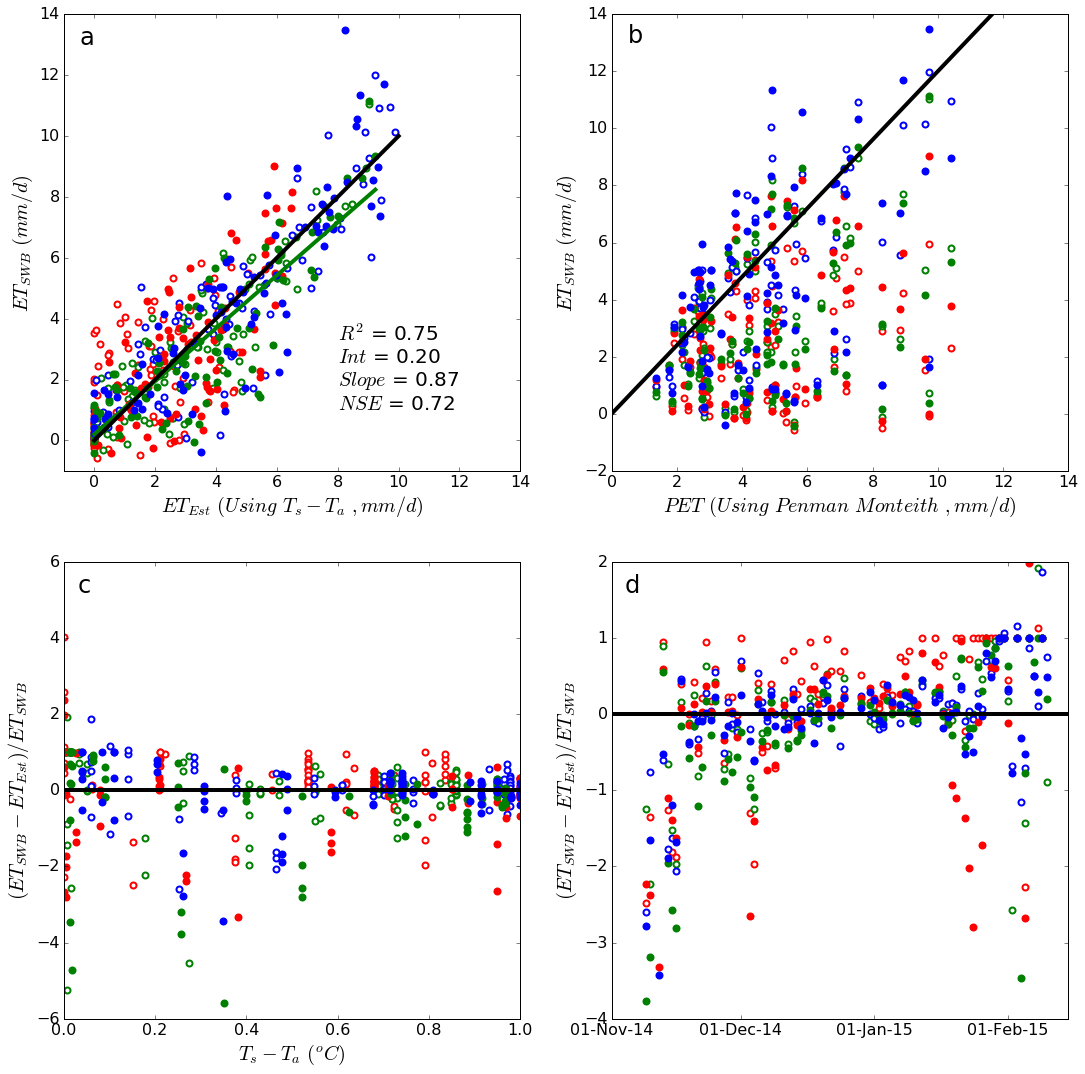

In [47]:
Colors = ['red', 'green', 'blue']
Markerfills = ['white','white','white','red', 'green', 'blue']
culpos = 0
Comparison = plt.figure(figsize = (18,18))
fig = Comparison.add_subplot(2,2,1)
for cul in Cultivars:
    irrpos = 0
    for irr in Irrigations:
        Y = EBMeans.ix[(cul,irr),'ET']
        X = EBMeans.ix[(cul,irr),'EstET']
        plt.plot(X,Y,'o',mec = Colors[irrpos],mfc=Markerfills[culpos],mew=2)
        irrpos+=1
        culpos+=1
#Make a binary filter to exclude High and Low reatments
ValidationFilter = (EBMeans.index.isin(['Mid'],level=1))#&(EBMeans.index.get_level_values(2)<'2015-01-15')
X = EBMeans.ix[ValidationFilter,'EstET'] 
Y = EBMeans.ix[ValidationFilter,'ET']
RegStats = MUte.MathUtilities.CalcRegressionStats('ET',Y,X)
Xs = []
Xs.append(X.min())
Xs.append(X.max())
Ys = []
Ys.append(RegStats.Intercept + Xs[0]*RegStats.Slope)
Ys.append(RegStats.Intercept + Xs[1]*RegStats.Slope)
plt.plot(Xs,Ys,'-', linewidth = 4, color='g')
plt.plot([0,10],[0,10],'-', linewidth = 4, color='k')
fitR2 = r'$R^2$ = ' + str(RegStats.R2)[:4]\
    + '\n$Int$ = ' + str(RegStats.Intercept)[:4] \
    + '\n$Slope$ = ' + str(RegStats.Slope)[:4]\
    + '\n$NSE$ = ' + str(RegStats.NSE)[:4] +''
plt.text(8,1.,fitR2,fontsize=20)        
plt.ylabel('$ET_{SWB}$ $(mm/d)$',fontsize=20)
plt.xlabel(r'$ET_{Est}$ $(Using$ $T_s-T_a$ $,mm/d)$',fontsize=20)
plt.tick_params(labelsize=16)
plt.text(-0.5,13,'a',fontsize=24)
plt.xlim(-1,14)
plt.ylim(-1,14)



fig = Comparison.add_subplot(2,2,2)
culpos = 0
for cul in Cultivars:
    irrpos = 0
    for irr in Irrigations:
        Y = EBMeans.ix[(cul,irr),'ET']
        #X = DayTimePET.ix[Y.index]
        X = EBMeans.ix[(cul,irr),'PET']
        plt.plot(X,Y,'o',mec = Colors[irrpos],mfc=Markerfills[culpos],mew=2)
        irrpos+=1
        culpos+=1
plt.plot([0,12],[0,14.4],'-', linewidth = 4, color='k')
plt.xlabel('$PET$ $(Using$ $Penman$ $Monteith$ $,mm/d)$',fontsize=20)
plt.tick_params(labelsize=16)
plt.ylim(-2,14)
plt.text(0.5,13,'b',fontsize=24)
plt.ylabel('$ET_{SWB}$ $(mm/d)$',fontsize=20)
#plt.legend(['Low Dash','Mid Dash','High Dash','Low Omaka','Mid Omaka','High Omaka'],loc=[-1.25,1.05],ncol=6,fontsize=18)
#plt.text(-8,16.5,'Irrigation level and cultivar treatments',fontsize=24)
plt.xlim(0,14)


fig = Comparison.add_subplot(2,2,3)
culpos = 0
for Cultivar in Cultivars:
    irrpos = 0 
    for Irrigation in Irrigations:
        yData = EstEnergyBalance.ix[(Cultivar,Irrigation),'ResidualET'].groupby(level='Date',axis=0).mean()
        yObs = EstEnergyBalance.ix[(Cultivar,Irrigation),'ET'].groupby(level='Date',axis=0).mean()
        xData = EstEnergyBalance.ix[(Cultivar,Irrigation),'GreenCover'].groupby(level='Date',axis=0).mean()
        plt.plot(xData,yData/yObs, 'o',  mec = Colors[irrpos],mfc=Markerfills[culpos],mew=2)
        irrpos += 1
        culpos +=1
plt.ylabel('$(ET_{SWB}-ET_{Est})/ET_{SWB}$', fontsize= 20)
plt.xlabel('$T_s-T_a$ $(^oC)$',fontsize=20)
plt.tick_params(labelsize = 16)
plt.text(0.03,5.2,'c',fontsize=24)
plt.ylim(-6,6)
plt.plot([0,1],[0,0],'-', linewidth = 4, color='k')

fig = Comparison.add_subplot(2,2,4)
culpos = 0
for Cultivar in Cultivars:
    irrpos = 0  
    for Irrigation in Irrigations:
        yData = EstEnergyBalance.ix[(Cultivar,Irrigation),'ResidualET'].groupby(level='Date',axis=0).mean()
        yObs = EstEnergyBalance.ix[(Cultivar,Irrigation),'ET'].groupby(level='Date',axis=0).mean()
        xData = yData.index
        plt.plot(xData,yData/yObs, 'o', mec = Colors[irrpos],mfc=Markerfills[culpos],mew=2)
        irrpos += 1
        culpos +=1
    plt.ylabel('$(ET_{SWB}-ET_{Est})/ET_{SWB}$', fontsize= 20)
plt.xlim('2014-11-1','2015-02-15')
fig.xaxis.set_major_locator(mdates.MonthLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
plt.tick_params(labelsize=16)
plt.text('2014-11-4',1.6,'d',fontsize=24)
plt.ylim(-4,2)
plt.plot(['2014-11-1','2015-02-15'],[0,0],'-', linewidth = 4, color='k')


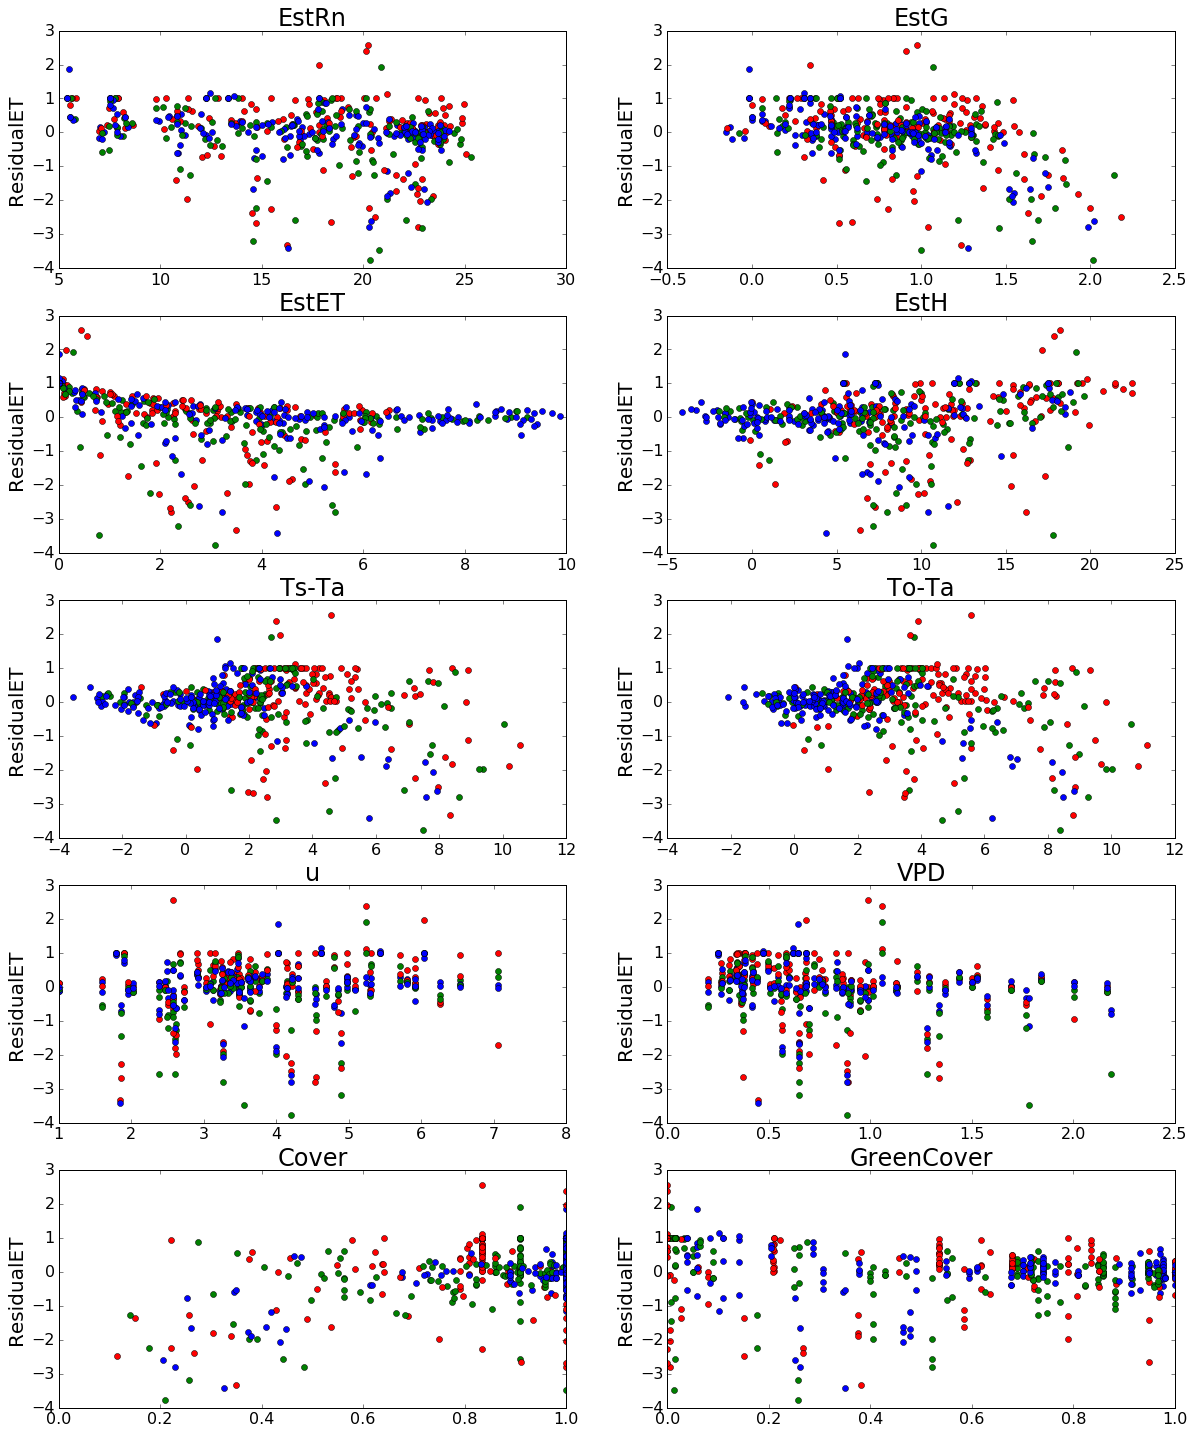

In [48]:
Comparison = plt.figure(figsize = (20,40))

Colors = ['red','green','blue']
Variables = ['EstRn','EstG','EstET','EstH','Ts-Ta','To-Ta','u','VPD','Cover','GreenCover']
Lines = ['--','-']
Position = 1
for Var in Variables:
    fig = Comparison.add_subplot(8,2,Position)
    LinePos=0
    for Cultivar in Cultivars:
        ColorPosition = 0   
        for Irrigation in Irrigations:
            xData = EstEnergyBalance.ix[(Cultivar,Irrigation),Var].groupby(level='Date',axis=0).mean()
            yData = EstEnergyBalance.ix[(Cultivar,Irrigation),'ResidualET'].groupby(level='Date',axis=0).mean()
            yObs = EstEnergyBalance.ix[(Cultivar,Irrigation),'ET'].groupby(level='Date',axis=0).mean()
            plt.plot(xData,yData/yObs, 'o',  color = Colors[ColorPosition],label = Cultivar+Irrigation)
            ColorPosition += 1
        plt.ylabel(yData.name, fontsize= 20)
        LinePos +=1
    plt.tick_params(labelsize = 16)
    plt.ylim(-4,3)
#     if Position == 6:
#         plt.ylim(0,200)
#     #plt.xlim(-4,12)
    #plt.legend(fontsize = 24)
    plt.title(Var, fontsize = 24)
    Position +=1


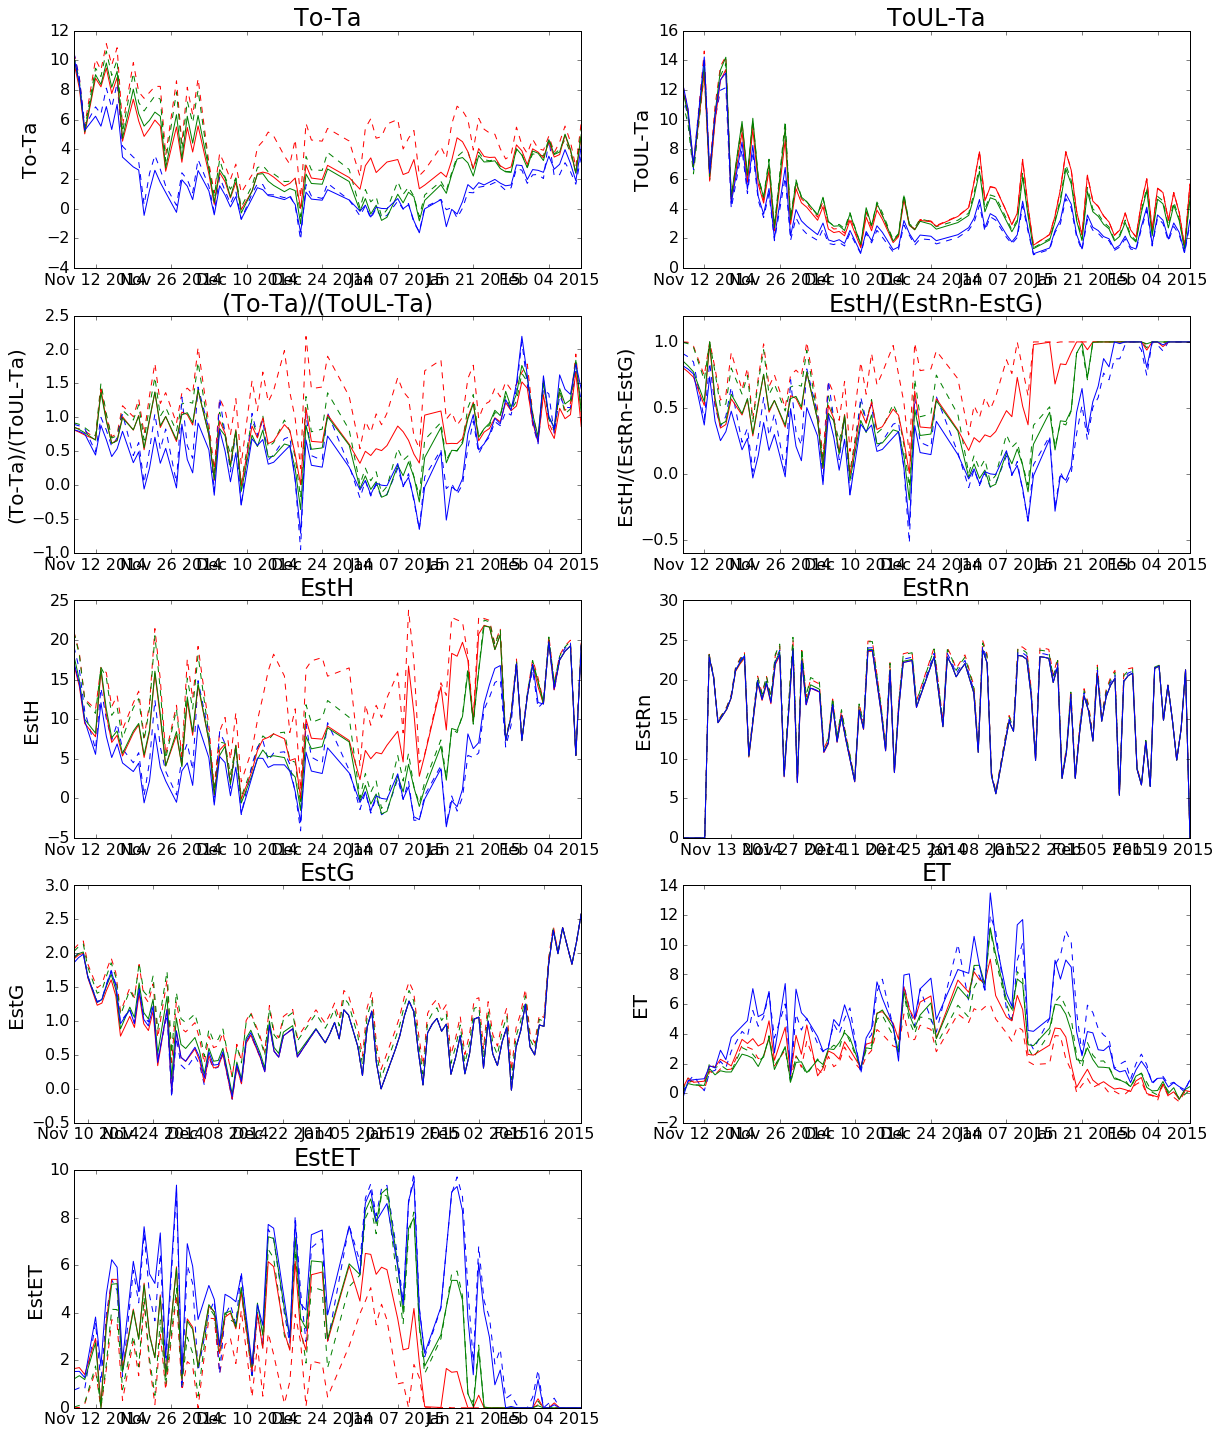

In [11]:
Comparison = plt.figure(figsize = (20,40))

Colors = ['red','green','blue']
Variables = ['To-Ta','ToUL-Ta','(To-Ta)/(ToUL-Ta)','EstH/(EstRn-EstG)','EstH','EstRn','EstG','ET','EstET']
Lines = ['--','-']
Position = 1
for Var in Variables:
    fig = Comparison.add_subplot(8,2,Position)
    LinePos=0
    for Cultivar in Cultivars:
        ColorPosition = 0   
        for Irrigation in Irrigations:
            yData = EstEnergyBalance.ix[(Cultivar,Irrigation),Var].groupby(level='Date',axis=0).mean()
            xData = yData.index.get_level_values('Date')
            plt.plot(xData,yData, Lines[LinePos], color = Colors[ColorPosition],label = Cultivar+Irrigation)
            ColorPosition += 1
        plt.ylabel(yData.name, fontsize= 20)
        LinePos +=1
    plt.tick_params(labelsize = 16)
#     if Position == 6:
#         plt.ylim(0,200)
#     #plt.xlim(-4,12)
    #plt.legend(fontsize = 24)
    plt.title(Var, fontsize = 24)
    Position +=1


In [12]:
FitSet = EstEnergyBalance.copy()
FitSet.index = FitSet.index.swaplevel('Date','Cultivar')
FitSet.sort_index(inplace=True)
FitSet = FitSet.ix['2014-12-01':'2015-01-01',:].copy()
FitSet.index = FitSet.index.swaplevel('Date','Cultivar')
FitSet.sort_index(inplace=True)

In [13]:
def MakeFitFrame(VPDInt,VPDSlope,ToTaSlope):
    Fits = FitSet.copy()
    Fits.ix[:,'To'] = Fits.ix[:,'Ts'] + VPDInt + Fits.ix[:,'VPD'] * VPDSlope
    Fits.ix[:,'To-Ta'] =  Fits.ix[:,'To'] -  Fits.ix[:,'Ta'] 
    Fits.ix[:,'TsUL'] = Fits.ix[:,'Ta'] + Fits.ix[:,'TsUL-Ta']
    Fits.ix[:,'ToUL'] = Fits.ix[:,'TsUL'] + VPDInt + Fits.ix[:,'VPD'] * VPDSlope
    Fits.ix[:,'ToUL-Ta'] = Fits.ix[:,'ToUL'] - Fits.ix[:,'Ta']
    Fits.ix[:,'(To-Ta)/(ToUL-Ta)'] = Fits.ix[:,'To-Ta']/Fits.ix[:,'ToUL-Ta']

    #Calculate the bowen ratio
    Fits.ix[:,'EstH/(EstRn-EstG)'] = Fits.ix[:,'(To-Ta)/(ToUL-Ta)'] * ToTaSlope
    Fits.ix[:,'EstH/(EstRn-EstG)'] = [min(Fits.ix[x,'EstH/(EstRn-EstG)'],1) for x in range(Fits.index.size)]
    Fits.ix[:,'EstH/(EstRn-EstG)'] = [max(Fits.ix[x,'EstH/(EstRn-EstG)'],-1) for x in range(Fits.index.size)]

    #The IRR on rep 2 of Dash High went on the blink after the 10th of Jan but the Equations to calculate H/(Rn-G) treat the missing data as zero so we need to delet the results 
    Fits.ix[('Dash','High','2'),'EstH/(EstRn-EstG)'].ix['2015-01-10':] = np.nan

    #Calculate estimated values for H and ET
    Fits.ix[:, 'EstH'] = Fits.ix[:, 'EstH/(EstRn-EstG)'] * Fits.ix[:,'EstRn-EstG']
    Fits.ix[:,'EstlE'] = Fits.ix[:,'EstRn'] - Fits.ix[:,'EstG'] - Fits.ix[:,'EstH']
    Fits.ix[:,'EstET'] = Fits.ix[:,'EstlE']/Fits.ix[:,'lamda']

    return Fits.ix[:,Fits.columns.isin(['ET','EstET'])]
    
def CalculateFits(Fits):
    X = Fits.ix[:,'EstET'] 
    Y = Fits.ix[:,'ET']
    ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
    Regres = ModTemp.fit(); 
    Coeffs = []
    Coeffs.append(VPDInt)
    Coeffs.append(VPDSlope)
    Coeffs.append(ToTaSlope)
    try:
        Coeffs.append(Regres.params[0])
    except:
        Coeffs.append(np.nan)
    try:
        Coeffs.append(Regres.params[1])
    except:
        Coeffs.append(np.nan)
    try:
        Coeffs.append(Regres.rsquared)
    except:
        Coeffs.append(np.nan)
    return Coeffs

In [14]:
Values = [-4,-3,-2,-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1,2,3,4]
FitsIndex = pd.MultiIndex.from_product([Values,Values,Values])
Results = pd.DataFrame(index = FitsIndex, columns = ['VPDInt','VPDSlope','ToTaSlope','Slope','Intercept','Rsq'])
for Val in Values:
    VPDInt = Val
    for Val in Values:
        VPDSlope = Val
        for Val in Values:
            ToTaSlope = Val
            Fits = MakeFitFrame(VPDInt,VPDSlope,ToTaSlope)
            Coeffs = CalculateFits(Fits)
            Results.ix[(VPDInt,VPDSlope,ToTaSlope),:] = Coeffs
        

KeyboardInterrupt: 

In [ ]:
Comparison = plt.figure(figsize = (20,40))

Colors = ['red','green','blue']
Variables = ['To-Ta']
Lines = ['--','-']
Position = 1
for Var in Variables:
    fig = Comparison.add_subplot(8,2,Position)
    LinePos=0
    for Cultivar in Cultivars:
        ColorPosition = 0   
        for Irrigation in Irrigations:
            yData = EstEnergyBalance.ix[(Cultivar,Irrigation),Var].groupby(level='Date',axis=0).mean()
            xData = yData.index.get_level_values('Date')
            plt.plot(xData,yData, Lines[LinePos], color = Colors[ColorPosition],label = Cultivar+Irrigation)
            ColorPosition += 1
        plt.ylabel(yData.name, fontsize= 20)
        LinePos +=1
    plt.tick_params(labelsize = 16)
#     if Position == 6:
#         plt.ylim(0,200)
#     #plt.xlim(-4,12)
    #plt.legend(fontsize = 24)
    plt.title(Var, fontsize = 24)
    Position +=1

    plt.ylim(-4,12)

In [ ]:
#Start off data frame with net radiation data W/m2
EstRn.name = 'EstRn'
EstEnergyBalance = pd.DataFrame(EstRn)

#Make soil heat flux data long and join into energy balance data frame
EstG.index.name='Date'
EstGLong = EstG.unstack()
EstGLong.name = 'EstG'
EstEnergyBalance = EstEnergyBalance.join(EstGLong)

#Make surface temperature data long and join into energy balance data frame
TsTa = np.subtract(DayTimeTnRDataMean.ix[:,'IR_SurfaceTemp'] , DayTimeTnRDataMean.ix[:,'AirTemperature'])
TsTaLong = TsTa.unstack()
TsTaLong.name = 'Ts-Ta'
EstEnergyBalance = EstEnergyBalance.join(TsTaLong)

#Duplicate Experiment level met data across all treatments and join into energy balance data frame
DateSet = EstEnergyBalance.ix[('Dash','Low','1'),:].index
TnRDataLong = DayTimeTnRDataMean.ix[DateSet].unstack()
LamdaSeries = makeSeries('lamda',TnRDataLong)
tempSeries = makeSeries('AirTemperature',TnRDataLong)
windSeries = makeSeries('Windspeed',TnRDataLong)
qSeries = makeSeries('q',TnRDataLong)
VPDSeries = makeSeries('VPD',TnRDataLong)
for plot in PlotList:
    #Hourly Water use in mm is equal to kg/m2 need to multiply by latent heat of vapourisation to convert to MJ
    EstEnergyBalance.ix[plot,'lamda'] = LamdaSeries.values
    EstEnergyBalance.ix[plot,'Ta'] = tempSeries.values
    EstEnergyBalance.ix[plot,'u'] = windSeries.values
    EstEnergyBalance.ix[plot,'q'] = qSeries.values
    EstEnergyBalance.ix[plot,'VPD'] = VPDSeries.values
    EstEnergyBalance.ix[plot,'PET'] = DayTimePET[EstEnergyBalance.ix[plot,'q'].index].values

#Join cover and green cover data into the data frame
EstEnergyBalance.ix[:,'Cover'] = CoverData.ix[DateSet].bfill().unstack()
EstEnergyBalance.ix[:,'GreenCover'] = GreenCoverData.ix[DateSet].bfill().unstack()
    
#Calculate some other values    
EstEnergyBalance.ix[:,'qCp'] = EstEnergyBalance.ix[:,'q'] * Cp
EstEnergyBalance.ix[:,'uVPD'] = EstEnergyBalance.ix[:,'u'] * EstEnergyBalance.ix[:,'VPD']
EstEnergyBalance.ix[:,'Ts-TaqCp'] = EstEnergyBalance.ix[:,'Ts-Ta'] * EstEnergyBalance.ix[:,'q'] * Cp
EstEnergyBalance.ix[:,'EstRn-EstG'] = EstEnergyBalance.ix[:,'EstRn'] - EstEnergyBalance.ix[:,'EstG']
#Make water use data long and join into energy balance dataset
ETLong = ET.unstack()
ETLong.name = 'ET'
EstEnergyBalance = EstEnergyBalance.join(ETLong)


In [ ]:

E0s = [-0.0015,-0.001,-0.0005]
E1s = [-0.0005]
EBs = [0.6]
C0s = [2]
C1s = [2]
CBs = [1]
D0s = [8000,6000,4000,2000,0]
D1s = [0]
DBs = [6]
Covers = ['GreenCover']

Index = pd.MultiIndex.from_product([E0s,E1s,EBs,C0s,C1s,CBs,D0s,D1s,DBs,Covers],names=['E0','E1','EB','C0','C1','CB','D0','D1','DB','Cov'])
Fits = pd.DataFrame(index = Index, columns = ['Int','Slope','R2'])

for E0 in E0s:
    for E1 in E1s:
        if E1 >= E0: #Don't test combinations that will bend the realtionship the wrong way
            for EB in EBs:
                for C0 in C0s:
                    for C1 in C1s:
                        for CB in CBs:
                            for D0 in D0s:
                                for D1 in D1s:
                                    if D1 <= D0: #Don't test combinations that will bend the realtionship the wrong way
                                        for DB in DBs:
                                            for Cov in Covers:
                                                #Calculate sensible heat model coefficients from green cover data
                                                EstEnergyBalance.ix[:,'E'] = E0 + ((E1-E0)/EB) * EstEnergyBalance.ix[:,Cov]
                                                EstEnergyBalance.ix[:,'E'] = [min(E1,EstEnergyBalance.ix[x,'E']) for x in range(EstEnergyBalance.index.size)]
                                                EstEnergyBalance.ix[:,'C'] = C0 + ((C1-C0)/CB) * EstEnergyBalance.ix[:,Cov]
                                                EstEnergyBalance.ix[:,'C'] = [max(C1,EstEnergyBalance.ix[x,'C']) for x in range(EstEnergyBalance.index.size)]
                                                EstEnergyBalance.ix[:,'D'] = D0 + ((D1-D0)/DB) *  EstEnergyBalance.ix[:,'uVPD']
                                                #EstEnergyBalance.ix[:,'D'] = [max(D1,EstEnergyBalance.ix[x,'D']) for x in range(EstEnergyBalance.index.size)]
                                                #Calculate the bowen ratio
                                                EstEnergyBalance.ix[:,'EstH/(EstRn-EstG)'] = EstEnergyBalance.ix[:,'C']/(1+np.exp((EstEnergyBalance.ix[:,'Ts-TaqCp'].values+EstEnergyBalance.ix[:,'D'])*EstEnergyBalance.ix[:,'E'])) - (EstEnergyBalance.ix[:,'C']/2)
                                                #The IRR on rep 2 of Dash High went on the blink after the 10th of Jan but the Equations to calculate H/(Rn-G) treat the missing data as zero so we need to delet the results 
                                                #EstEnergyBalance.ix[('Dash','High','2'),'EstH/(EstRn-EstG)'].ix['2015-01-10':] = np.nan

                                                #Calculate estimated values for H and ET
                                                EstEnergyBalance.ix[:, 'EstH'] = EstEnergyBalance.ix[:, 'EstH/(EstRn-EstG)'] * EstEnergyBalance.ix[:,'EstRn-EstG']
                                                EstEnergyBalance.ix[:,'EstlE'] = EstEnergyBalance.ix[:,'EstRn'] - EstEnergyBalance.ix[:,'EstG'] - EstEnergyBalance.ix[:,'EstH']
                                                EstEnergyBalance.ix[:,'EstET'] = EstEnergyBalance.ix[:,'EstlE']/EstEnergyBalance.ix[:,'lamda']

                                                #Calculate residual
                                                EstEnergyBalance.ix[:,'ResidualET'] = EstEnergyBalance.ix[:,'ET'] - EstEnergyBalance.ix[:,'EstET']

                                                #make a dataframe with treatment means
                                                EstEBreorder = EstEnergyBalance.copy()
                                                EstEBreorder.index = EstEnergyBalance.index.swaplevel('Date','Cultivar')
                                                EstEBreorder.index = EstEnergyBalance.index.swaplevel('Irrigation','Block')
                                                EBMeans = EstEBreorder.groupby(level=('Cultivar','Irrigation','Date'),axis=0).mean()

                                                X = EBMeans.ix[:,'EstET'] 
                                                Y = EBMeans.ix[:,'ET']
                                                ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                                                                        sm.add_constant(X), # X variable
                                                                                        missing='drop',                                     # ignor and data where one value is missing
                                                                                        hasconst=False) 
                                                Regres = ModTemp.fit(); 

                                                Fits.ix[(E0,E1,EB,C0,C1,CB,D0,D1,DB,Cov),'Int'] = Regres.params.const
                                                Fits.ix[(E0,E1,EB,C0,C1,CB,D0,D1,DB,Cov),'Slope'] = Regres.params.EstET
                                                Fits.ix[(E0,E1,EB,C0,C1,CB,D0,D1,DB,Cov),'R2'] = Regres.rsquared

In [ ]:
Filter = (Fits.Int>-0.1)&(Fits.Int<0.1)&(Fits.Slope<1.1)&(Fits.Slope>0.9)
Fits#.ix[Filter]

In [ ]:
EstEnergyBalance.ix[('Dash','High','2'),'EstH/(EstRn-EstG)'].ix['2015-01-10':]

In [ ]:
Index = pd.MultiIndex.from_product([E0s,E1s,EBs,C0s,C1s,CBs,D0s,D1s,DBs,Covers])

In [ ]:
Regres.params


In [ ]:
Regres.rsquared

In [ ]:
Colors = ['red', 'green', 'blue']
Markerfills = ['white','white','white','red', 'green', 'blue']
culpos = 0
Comparison = plt.figure(figsize = (18,18))
fig = Comparison.add_subplot(2,2,1)
for cul in Cultivars:
    irrpos = 0
    for irr in Irrigations:
        Y = EBMeans.ix[(cul,irr),'ET']
        X = EBMeans.ix[(cul,irr),'EstET']
        plt.plot(X,Y,'o',mec = Colors[irrpos],mfc=Markerfills[culpos],mew=2)
        irrpos+=1
        culpos+=1

In [ ]:
EstET

In [ ]:
Comparison = plt.figure(figsize = (20,40))

Colors = ['red','green','blue']
Variables = ['C','D','E','EstRn','EstG','EstH','Ts-Ta','EstH/(EstRn-EstG)','Ta','ET']
Lines = ['--','-']
Position = 1
for Var in Variables:
    fig = Comparison.add_subplot(8,2,Position)
    LinePos=0
    for Cultivar in Cultivars:
        ColorPosition = 0   
        for Irrigation in Irrigations:
            yData = EstEnergyBalance.ix[(Cultivar,Irrigation),Var].groupby(level='Date',axis=0).mean()
            xData = yData.index.get_level_values('Date')
            plt.plot(xData,yData, Lines[LinePos], color = Colors[ColorPosition],label = Cultivar+Irrigation)
            ColorPosition += 1
        plt.ylabel(yData.name, fontsize= 20)
        LinePos +=1
    plt.tick_params(labelsize = 16)
#     if Position == 6:
#         plt.ylim(0,200)
#     #plt.xlim(-4,12)
    #plt.legend(fontsize = 24)
    plt.title(Var, fontsize = 24)
    Position +=1
